In [1]:
from PIL import Image
import numpy as np
import gym
import gym_snake

from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, \
    Convolution2D, Permute, Input, Lambda
from keras.optimizers import Adam
import keras.backend as K

from keras.models import model_from_config
import tensorflow as tf
from collections import deque
import random

from IPython.display import display
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
ENV_NAME = 'snake-v0'  # Environment name
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
INPUT_SHAPE = (FRAME_WIDTH, FRAME_HEIGHT)
WINDOW_LENGTH = 4  # Number of most recent frames to produce the input to the network (WINDOW LENGTH)

NUM_STEPS = 2_000_005

EXPLORATION_STEPS = 1_000_005  # Number of steps over which the initial value # of epsilon is linearly annealed to its final value
INITIAL_EPSILON = 1.0  # Initial value of epsilon in epsilon-greedy
FINAL_EPSILON = 0.1  # Final value of epsilon in epsilon-greedy

OBSERVE = 20_000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 400_000  # Number of replay memory the agent uses for training
BATCH_SIZE = 32  # Mini batch size
TARGET_UPDATE_INTERVAL = 10_000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects 4 actions between successive updates

LEARNING_RATE = 0.00025  # Learning rate used by optimizer
GAMMA = 0.99  # Discount factor

SAVE_INTERVAL = 200_000  # The frequency with which the network is saved
NO_OP_STEPS = 7  # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode

SAVE_NETWORK_PATH = 'saved_networks/' + ENV_NAME
SAVE_SUMMARY_PATH = 'summary/' + ENV_NAME

In [3]:
def get_env():
    env = gym.make(ENV_NAME)
    env.n_foods = 3
    env.grid_size = [20, 20]
    env.unit_size = 10
    env.unit_gap = 1
    env.wall = True
    env.random_init = True
    return env

Grid Size:  [20 20]
Image shape before pre-processing:  (200, 200, 3)
Image shape after pre-processing:  (84, 84)
No. of actions:  4

Before Preprocessing:


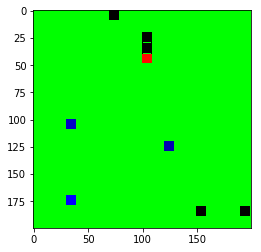


After Preprocessing:


/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


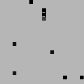

<Figure size 432x288 with 0 Axes>

In [4]:
env = get_env()
x_t = env.reset()

# Controller
game_controller = env.controller
# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid
print('Grid Size: ', grid_object.grid_size)
# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

state_shape = grid_pixels.shape
print('Image shape before pre-processing: ', state_shape)
print('Image shape after pre-processing: ', (FRAME_WIDTH, FRAME_HEIGHT))
nb_actions = env.action_space.n
print('No. of actions: ', nb_actions)

print('\nBefore Preprocessing:')
env.render()

print('\nAfter Preprocessing:')

processed_image = np.uint8(resize(rgb2gray(x_t), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
img = Image.fromarray(processed_image)
display(img)

In [5]:
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE


def r(raw):
    raw = [f.reshape((1,) + INPUT_SHAPE) for f in raw]
    raw = np.asarray(raw).reshape(input_shape)
    raw = np.expand_dims(raw, axis=0)
    return raw


def process_observation(observation):
    assert observation.ndim == 3  # (height, width, channel)
    img = Image.fromarray(observation)
    img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
    processed_observation = np.array(img)
    assert processed_observation.shape == INPUT_SHAPE
    return processed_observation.astype('uint8') / 255.  # saves storage in experience memory


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)


def get_model():
    model = Sequential()
    if K.image_dim_ordering() == 'tf':
        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
    elif K.image_dim_ordering() == 'th':
        # (channels, width, height)
        model.add(Permute((1, 2, 3), input_shape=input_shape))
    else:
        raise RuntimeError('Unknown image_dim_ordering.')
    print('INPUT SHAPE: ', input_shape)
    model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    return model


model = get_model()
print(model.summary())
model.compile(loss=huber_loss, optimizer=Adam(lr=LEARNING_RATE), metrics=['mae'])

target_model = get_model()
target_model.compile(loss=huber_loss, optimizer=Adam(lr=LEARNING_RATE), metrics=['mae'])


def get_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(env.action_space.n)
    if random.random() < 0.5:
        act_values = model.predict(r(state))
    else:
        act_values = target_model.predict(r(state))
    return np.argmax(act_values[0])


def get_test_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(env.action_space.n)
    act_values = model.predict(r(state))
    return np.argmax(act_values[0])


def update_model():
    minibatch = random.sample(memory, BATCH_SIZE)
    total_loss = 0.
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            best_action = np.argmax(model.predict(r(next_state))[0])
            target = (reward + GAMMA * target_model.predict(r(next_state))[0][best_action])
        target_f = model.predict(r(state))
        target_f[0][action] = target
        h = model.fit(r(state), target_f, epochs=1, verbose=0)
        total_loss += h.history['loss'][0]
    return total_loss


def update_target():
    minibatch = random.sample(memory, BATCH_SIZE)
    total_loss = 0.
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            best_action = np.argmax(target_model.predict(r(next_state))[0])
            target = (reward + GAMMA * model.predict(r(next_state))[0][best_action])
        target_f = target_model.predict(r(state))
        target_f[0][action] = target
        h = model.fit(r(state), target_f, epochs=1, verbose=0)
        total_loss += h.history['loss'][0]
    return total_loss


def replay():
    if random.random() > 0.5:
        return update_target()
    else:
        return update_model()


def setup_summary():
    episode_total_reward = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Total_Reward/Episode', episode_total_reward)
    episode_avg_max_q = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Average_Max_Q/Episode', episode_avg_max_q)
    episode_duration = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Duration/Episode', episode_duration)
    episode_avg_loss = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Average_Loss/Episode', episode_avg_loss)
    epsilon = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Epsilon/Episode', epsilon)
    curr_time_step = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Steps/Episode', curr_time_step)

    summary_vars = [episode_total_reward, episode_avg_max_q, episode_duration, episode_avg_loss, epsilon,
                    curr_time_step]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op
# def get_initial_state(self, observation):
#     processed_observation = np.uint8(resize(rgb2gray(observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
#     state = [processed_observation for _ in range(WINDOW_LENGTH)]
#     return np.stack(state, axis=0)


INPUT SHAPE:  (4, 84, 84)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)     

INPUT SHAPE:  (4, 84, 84)


In [6]:
memory = deque(maxlen=NUM_REPLAY_MEMORY)
state = deque(maxlen=WINDOW_LENGTH)

env = get_env()
observation = env.reset()
observation = process_observation(observation)
state.append(observation)
state.append(observation)
state.append(observation)
state.append(observation)

current = [observation for _ in range(WINDOW_LENGTH)]
previous = [observation for _ in range(WINDOW_LENGTH)]

# Parameters used for summary
total_reward = 0.
total_q_max = 0.
total_loss = 0.
duration = 0
episode = 0

sess = tf.InteractiveSession()
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter(SAVE_SUMMARY_PATH, sess.graph)
sess.run(tf.initialize_all_variables())
epsilon = INITIAL_EPSILON

for t in tqdm(range(NUM_STEPS)):
    action = get_action(current, epsilon)

    observation, reward, terminal, _ = env.step(int(action))
    observation = process_observation(observation)
    total_reward += reward
    duration += 1

    total_q_max += np.argmax(model.predict(r(state)))
    state.append(observation)

    # Remember
    current = list(state)
    memory.append((previous, action, reward, current, terminal))
    previous = current

    if t > OBSERVE:
        # Train
        if t % TRAIN_INTERVAL == 0:
            total_loss += replay()
        
        # Save Weights Interval
        if t % SAVE_INTERVAL == 0:
            model.save_weights((SAVE_NETWORK_PATH + '/snake2_{}.h5').format(t))
    
        # Update Target Network
        if t % TARGET_UPDATE_INTERVAL == 0:
            target_model.set_weights(model.get_weights())
        
        # Exploration Rate Decay
        if epsilon > FINAL_EPSILON:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS

    # End of episode
    if terminal:
        # Writing Summary Log
        avg_q = total_q_max / float(duration)
        avg_loss = total_loss / (float(duration) / float(TRAIN_INTERVAL))
        if t >= OBSERVE:
            stats = [total_reward, avg_q, duration, avg_loss, float(epsilon), float(t)]

            for i in range(len(stats)):
                sess.run(update_ops[i], feed_dict={
                    summary_placeholders[i]: float(stats[i])
                })
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, episode + 1)

        # Debug
        if t < OBSERVE:
            mode = 'random'
        elif OBSERVE <= t < OBSERVE + EXPLORATION_STEPS:
            mode = 'explore'
        else:
            mode = 'exploit'
        print(
            'EPISODE: {0:6d} / TIMESTEP: {1:8d} / DURATION: {2:5d} /'
            ' EPSILON: {3:.5f} / TOTAL_REWARD: {4:3.0f} / '
            'AVG_MAX_Q: {5:2.4f} / AVG_LOSS: {6:.5f} / MODE: {7}'.format(
                episode + 1, t, duration, epsilon,
                total_reward, avg_q, avg_loss, mode))

        total_reward = 0.
        total_q_max = 0.
        total_loss = 0.
        duration = 0
        episode += 1

        observation = env.reset()
        for _ in range(random.randint(1, NO_OP_STEPS)):
            observation, _, terminal, _ = env.step(env.action_space.sample())  # Do nothing
            if terminal:
                observation = env.reset()
                break
        observation = process_observation(observation)
        state = deque(maxlen=WINDOW_LENGTH)
        state.append(observation)
        state.append(observation)
        state.append(observation)
        state.append(observation)
        current = [observation for i in range(4)]
        previous = [observation for i in range(4)]

model.save_weights(SAVE_NETWORK_PATH + '/snake2_final.h5')

Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/2000005 [00:00<?, ?it/s]

  0%|          | 1/2000005 [00:00<64:53:10,  8.56it/s]

  0%|          | 18/2000005 [00:00<46:26:58, 11.96it/s]

  0%|          | 32/2000005 [00:00<33:45:16, 16.46it/s]

  0%|          | 46/2000005 [00:00<24:52:01, 22.34it/s]

  0%|          | 64/2000005 [00:00<18:23:53, 30.20it/s]

  0%|          | 81/2000005 [00:00<13:51:33, 40.08it/s]

  0%|          | 97/2000005 [00:00<10:45:02, 51.67it/s]

  0%|          | 117/2000005 [00:00<8:22:18, 66.36it/s]

EPISODE:      1 / TIMESTEP:       94 / DURATION:    95 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.3053 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      2 / TIMESTEP:      131 / DURATION:    37 / EPSILON: 1.00000 / TOTAL_REWARD:   5 / AVG_MAX_Q: 1.4595 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 135/2000005 [00:00<6:50:45, 81.15it/s]

  0%|          | 154/2000005 [00:01<5:40:22, 97.92it/s]

  0%|          | 173/2000005 [00:01<4:52:53, 113.80it/s]

  0%|          | 193/2000005 [00:01<4:17:27, 129.46it/s]

  0%|          | 213/2000005 [00:01<3:51:25, 144.02it/s]

EPISODE:      3 / TIMESTEP:      173 / DURATION:    42 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.7381 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      4 / TIMESTEP:      194 / DURATION:    21 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 2.2857 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      5 / TIMESTEP:      211 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 2.2353 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 232/2000005 [00:01<3:34:50, 155.13it/s]

  0%|          | 253/2000005 [00:01<3:18:35, 167.83it/s]

EPISODE:      6 / TIMESTEP:      213 / DURATION:     2 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 273/2000005 [00:01<3:15:11, 170.74it/s]

EPISODE:      7 / TIMESTEP:      254 / DURATION:    41 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 1.5610 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      8 / TIMESTEP:      293 / DURATION:    39 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 2.0513 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 294/2000005 [00:01<3:05:49, 179.35it/s]

  0%|          | 314/2000005 [00:01<3:02:19, 182.79it/s]

  0%|          | 336/2000005 [00:01<2:53:57, 191.59it/s]

  0%|          | 357/2000005 [00:02<2:51:43, 194.08it/s]

  0%|          | 379/2000005 [00:02<2:47:18, 199.20it/s]

EPISODE:      9 / TIMESTEP:      354 / DURATION:    61 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 1.8525 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     10 / TIMESTEP:      366 / DURATION:    12 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     11 / TIMESTEP:      384 / DURATION:    18 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 2.0556 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 400/2000005 [00:02<2:53:33, 192.01it/s]

  0%|          | 420/2000005 [00:02<2:52:47, 192.88it/s]

  0%|          | 440/2000005 [00:02<2:51:07, 194.75it/s]

EPISODE:     12 / TIMESTEP:      403 / DURATION:    19 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.6316 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 460/2000005 [00:02<3:01:52, 183.23it/s]

  0%|          | 481/2000005 [00:02<2:56:00, 189.34it/s]

  0%|          | 502/2000005 [00:02<2:52:51, 192.79it/s]

  0%|          | 523/2000005 [00:02<2:49:53, 196.16it/s]

  0%|          | 544/2000005 [00:03<2:46:43, 199.88it/s]

EPISODE:     13 / TIMESTEP:      507 / DURATION:   104 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 1.2115 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 565/2000005 [00:03<2:48:47, 197.43it/s]

  0%|          | 585/2000005 [00:03<2:48:56, 197.24it/s]

  0%|          | 607/2000005 [00:03<2:44:00, 203.19it/s]

EPISODE:     14 / TIMESTEP:      569 / DURATION:    62 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 1.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 628/2000005 [00:03<2:46:39, 199.96it/s]

  0%|          | 650/2000005 [00:03<2:43:37, 203.66it/s]

  0%|          | 671/2000005 [00:03<2:43:08, 204.26it/s]

KeyboardInterrupt: 

In [8]:
%matplotlib
for e in tqdm(range(10)):
    state = deque(maxlen=WINDOW_LENGTH)
    env = get_env()
    observation = env.reset()
    observation = process_observation(observation)
    state.append(observation)
    state.append(observation)
    state.append(observation)
    state.append(observation)

    current = [observation for _ in range(WINDOW_LENGTH)]

    total_reward = 0.
    duration = 0
    episode = 0

    terminal = False
    while not terminal:
        action = get_test_action(current, 0.)
        # env.render()
        observation, reward, terminal, _ = env.step(int(action))
        observation = process_observation(observation)
        total_reward += reward
        duration += 1

        state.append(observation)

        # Remember
        current = list(state)

        if duration >= 600:
            print(duration)
            break

    print(total_reward, duration)


  0%|          | 0/10 [00:00<?, ?it/s]

Using matplotlib backend: Qt5Agg


 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

15.0 285


 20%|██        | 2/10 [00:01<00:08,  1.08s/it]

 30%|███       | 3/10 [00:01<00:05,  1.26it/s]

3.0 96
2.0 25


 40%|████      | 4/10 [00:02<00:05,  1.19it/s]

9.0 181


 50%|█████     | 5/10 [00:04<00:05,  1.07s/it]

12.0 360


 60%|██████    | 6/10 [00:05<00:04,  1.12s/it]

11.0 282


 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

4.0 122


 80%|████████  | 8/10 [00:06<00:01,  1.20it/s]

3.0 131


 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

6.0 213


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

10.0 216
